Os modelos que usei para a dissertação nao tem o ruído de saída como parâmetro (são fixos durante todo o treino e determinados por validação cruzada), com excessão do **Probabilistic Backprop** (**PBP**) cuja saída é média e variância preditivas e a variância estimada para o ruído aditivo de observação.

Uma abordagem mais interessante é estabelecer tal variável de ruído como parâmetro tunável interno do modelo. Como participa do cálculo da função objetivo, terá seu valor atualizado pelo otimizador. Nesse caso, haverá um parâmetro de ruído único para toda e qualquer entrada, logo o modelo será homocedástico. Note que esse representará o ruído dos dados (incerteza aleátoria) e não a do modelo (incerteza epistêmica), essa última é calculada fazendo-se MC nos pesos da rede e calculando a variância observada. Caso se deseje que o modelo seja capaz de predizer a incerteza heterocedástica, o parâmetro de variância deverá fazer parte da saída da rede. Os dois tipos de variância podem coexistir no modelo.

Para que sejam compatíveis com o **PBP**, certamente deve ser implementado nos outros modelos a capacidade de prever o ruído aditivo de saída (o parâmetro tunável atrelado ao modelo). E quanto a predição da variância pela rede, deve ser inclusa também ou apenas a oriunda da integração por amostragem de MC é suficiente?

Refletindo sobre o significado e origem desses dois termos, chega-se a conclusão que o MC é suficiente para os outros modelos e a rede não deve prever um termo de variância. Esse último corresponde a uma variânca que a rede preve para a *entrada* enquanto o PBP calcula sua variância analiticamente a partir da distribuição dos *pesos* e isso (variância oriunda dos pesos) é feito nos outros modelos por MC.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import theano
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch import autograd

from bayesnn.datasets import Dataset

from bayesnn.uci_code.experiments_pbp import ExperimentPBPReg
from bayesnn.uci_code.experiments import ExperimentBBBMLPReg, ExperimentVadamMLPReg, ExperimentDropoutMLPReg

from bayesnn.utils import plot_1d_results

In [3]:
sns.set('paper', 'white', 'colorblind', font_scale=2.2,
        rc={'lines.linewidth': 2,
            'lines.markersize': 10,
            'figure.figsize': (12.0, 12.0),
            'image.interpolation': 'nearest',
            'image.cmap': 'gray',
            'text.usetex' : True,
            }
        )

In [4]:
def plot_curve(x_train, y_train, x_domain, means, aleatoric, epistemic, ideal_output=None):
    total_unc = (aleatoric**2 + epistemic**2)**0.5

    fig = plt.figure(figsize = (6, 5))
    plt.style.use('default')
    c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    plt.scatter(x_train, y_train, s = 10, marker = 'x', color = c[3], alpha = 0.5)

    plt.fill_between(x_domain, means + aleatoric, means + total_unc, color = c[0], alpha = 0.3, label = r'$\sigma(y^*|x^*)$')
    plt.fill_between(x_domain, means - total_unc, means - aleatoric, color = c[0], alpha = 0.3)
    plt.fill_between(x_domain, means - aleatoric, means + aleatoric, color = c[1], alpha = 0.4, label = r'$\EX[\sigma^2]^{1/2}$')

    plt.plot(x_domain, means, color = 'black', linewidth = 1)
    
    if ideal_output is not None:
        plt.plot(x_domain, ideal_output, color = c[1], linewidth = 1)
    
    # plt.xlim([-5, 5])
    # plt.ylim([-12, 12])
    plt.xlabel('$x$')
    plt.ylabel('$y$')

    plt.gca().yaxis.grid(alpha=0.3)
    plt.gca().xaxis.grid(alpha=0.3)
    
    return fig


## Toy set #1

https://github.com/microsoft/deterministic-variational-inference/blob/master/ToyData.ipynb

In [12]:
import GPy

np.random.seed(2)
no_points = 400
lengthscale = 1
variance = 1.0
sig_noise = 0.3
x = np.random.uniform(-3, 3, no_points)[:, None]
x.sort(axis = 0)

k = GPy.kern.RBF(input_dim = 1, variance = variance, lengthscale = lengthscale)
C = k.K(x, x) + np.eye(no_points)*sig_noise**2

y = np.random.multivariate_normal(np.zeros((no_points)), C)[:, None]
y = (y - y.mean())
x_train = x[75:325]
y_train = y[75:325]

# Do similar procedure to create test samples (using the whole range)
x_test = np.random.uniform(-5, 5, 100)[:, None]
x_test.sort(axis = 0)
C_test = k.K(x_test, x_test) + np.eye(100)*sig_noise**2
y_test = np.random.multivariate_normal(np.zeros((100)), C_test)[:, None]
y_test = (y_test - y_test.mean())

# X domain for visualizing learned model
x_domain = torch.linspace(-5,5,100)[..., None]

In [5]:
# np.random.seed(seed)

def base_model(x):
    return -(x+0.5)*np.sin(3 * np.pi *x)

def noise_model(x):
    return 0.11*np.ones_like(x)
#     return 0.45*(x+0.5)**2

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

train_size, test_size = 400, 100

# X values: U[-0.3, 0.3]
x_train = 0.6*np.random.rand(train_size, 1) - 0.3
y_train = sample_data(x_train)

# Y values: U[-0.5, 0.5]
x_test = np.random.rand(test_size, 1) - 0.5
y_test = sample_data(x_test)

# X domain for visualizing learned model
x_domain = torch.linspace(-1,1,100)[..., None]

<IPython.core.display.Javascript object>


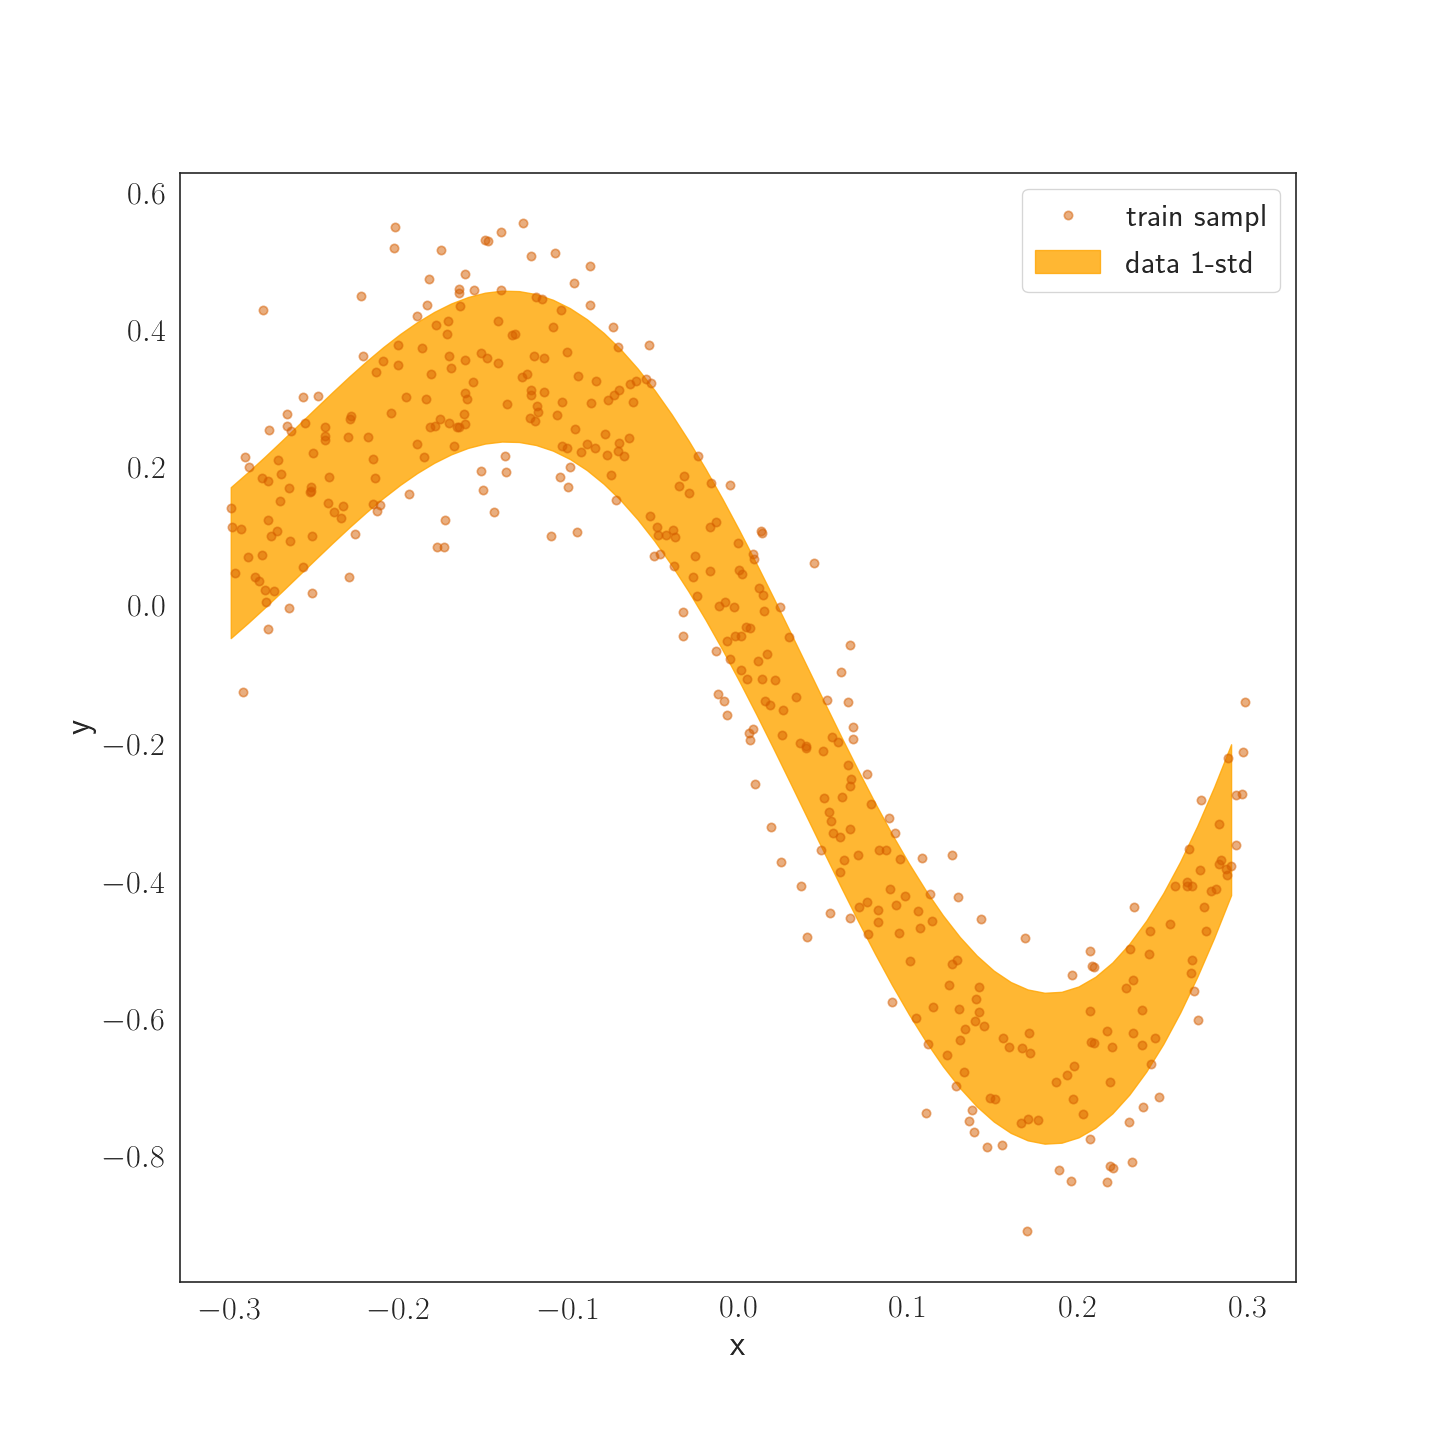

In [6]:
data = Dataset('toydata1d', x_points=(x_train, x_test), y_points=(y_train, y_test))

plot_1d_results((data.train_set.train_data.numpy(), data.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model})

# filename = 'ex1_data_samples.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

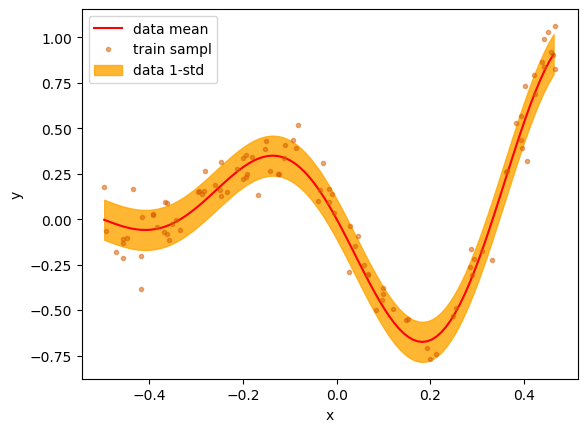

In [84]:
plot_1d_results((data.test_set.test_data.numpy(), data.test_set.test_labels.numpy()),
                 {'mean':base_model, 'std':noise_model})


## Bayes By Backprop (BBB)

In [9]:
model_params={'hidden_sizes': [100],
              'act_func': 'relu' ,
#               'prior_prec': lengthscale**2, # = 1
              'prior_prec': 1, # = 1
              'noise_prec': 1/0.11**2 * y_train.var()}

train_params={'batch_size': len(x_train),
              'num_epochs': 2000,
              'seed': 2,
              'train_mc_samples': 10,
              'eval_mc_samples': 100}

dataset = 'toydata1d'
data_params={'x_points': (x_train, x_test),
             'y_points': (y_train, y_test)}

optim_params={'optim': 'adam',
              'learning_rate': 0.01,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

BBB = ExperimentBBBMLPReg(dataset,
                            model_params,
                            train_params,
                            optim_params,
                            data_params,
                            evals_per_epoch=1,
                            normalize_x=True,
                            normalize_y=True,
                            use_cuda=torch.cuda.is_available(),
                            print_freq=199
    )

BBB.run(log_metric_history=False)

Dataset: toydata1d   , Epoch [ 1/2000], Loss: 34.4211 Batch time: 0.038 (0.038) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [200/2000], Loss: 3.3626 Batch time: 0.024 (0.024) Data time: 0.007 (0.007) 
Dataset: toydata1d   , Epoch [399/2000], Loss: 2.0511 Batch time: 0.016 (0.016) Data time: 0.004 (0.004) 
Dataset: toydata1d   , Epoch [598/2000], Loss: 1.2899 Batch time: 0.015 (0.015) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [797/2000], Loss: 1.1675 Batch time: 0.027 (0.027) Data time: 0.007 (0.007) 
Dataset: toydata1d   , Epoch [996/2000], Loss: 1.0735 Batch time: 0.026 (0.026) Data time: 0.007 (0.007) 
Dataset: toydata1d   , Epoch [1195/2000], Loss: 1.0337 Batch time: 0.026 (0.026) Data time: 0.007 (0.007) 
Dataset: toydata1d   , Epoch [1394/2000], Loss: 1.0054 Batch time: 0.022 (0.022) Data time: 0.005 (0.005) 
Dataset: toydata1d   , Epoch [1593/2000], Loss: 0.9589 Batch time: 0.026 (0.026) Data time: 0.007 (0.007) 
Dataset: toydata1d   , Epoch [1792/2000], L

0.8859578967094421

<IPython.core.display.Javascript object>


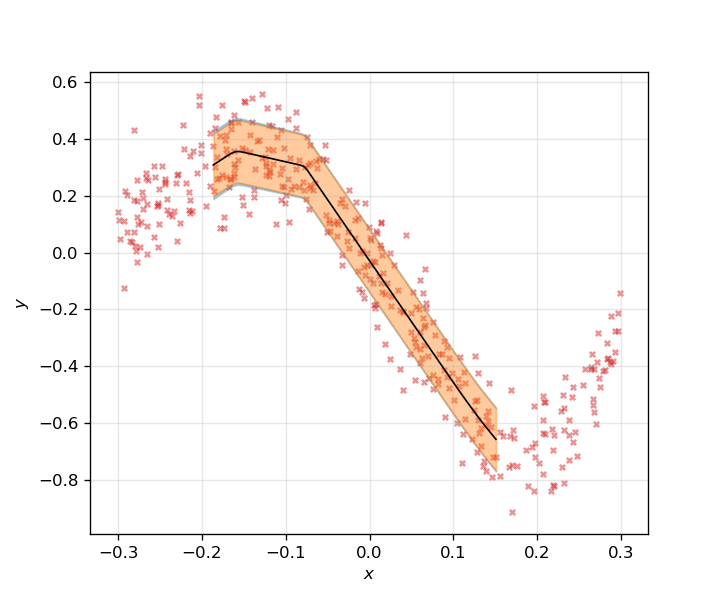

In [11]:
x_mean, x_std = BBB.x_means.cpu().numpy(), BBB.x_stds.cpu().numpy()
y_mean, y_std = BBB.y_mean.cpu().numpy(), BBB.y_std.cpu().numpy()

out = BBB.prediction(x_domain, train=False)
out = torch.stack(out).cpu().detach().numpy()
out = out*y_std + y_mean

means = out.mean(axis = 0)

# aleatoric = 1/np.sqrt(BBB.model.log_noise.cpu().exp().detach().item())
aleatoric = torch.exp(-0.5*BBB.log_noise.detach()).item()*y_std
epistemic = out.var(axis = 0)**0.5

fig = plot_curve(x_train, y_train, x_domain.view(-1).cpu().numpy()*x_std + x_mean,  means, aleatoric, epistemic)

## Monte Carlo Dropout (MCDO)

In [226]:
model_params={'hidden_sizes': [100],
              'act_func': 'relu' ,
              'dropout': 0.05 ,
              'prior_prec': lengthscale, # lengthscale = 1
              'noise_prec': 1/sig_noise**2 * y_train.var()}

train_params={'batch_size': len(x_train),
              'num_epochs': 10000, # 20000
              'seed': 2,
              'train_mc_samples': 1,
              'eval_mc_samples': 100}

optim_params={'optim': 'adam',
              'learning_rate': 0.01,
#               'betas': 0.,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

dataset = 'toydata1d'
data_params={'x_points': (x_train, x_test),
             'y_points': (y_train, y_test)}

# Manually set a value for weight decay (wd) by forcing the prior precision
# wd = 1e-4
# model_params['prior_prec'] = 10
# model_params['prior_prec'] = (2 * model_params['noise_prec'] * len(x_train))*wd/(1 - model_params["dropout"])

print('prior prec', model_params['prior_prec'])
print('lenghtscale', np.sqrt(model_params["prior_prec"]))
print('wd', (1 - model_params["dropout"]) * np.sqrt(model_params["prior_prec"]) ** 2 / (2 * model_params["noise_prec"] * len(x_train)))

prior prec 1
lenghtscale 1.0
wd 7.143151739036676e-05


In [85]:
Dropout = ExperimentDropoutMLPReg(dataset,
                                    model_params,
                                    train_params,
                                    optim_params,
                                    data_params=data_params,
                                    evals_per_epoch=1,
                                    normalize_x=True,
                                    normalize_y=True,
                                    use_cuda=torch.cuda.is_available(),
                                    print_freq=1999)

Dropout.run(log_metric_history=False)

Dataset: toydata1d   , Epoch [ 1/10000], Loss: 0.5935 Batch time: 0.010 (0.010) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [2000/10000], Loss: 0.0434 Batch time: 0.005 (0.005) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [3999/10000], Loss: 0.0412 Batch time: 0.005 (0.005) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [5998/10000], Loss: 0.0348 Batch time: 0.006 (0.006) Data time: 0.004 (0.004) 
Dataset: toydata1d   , Epoch [7997/10000], Loss: 0.0354 Batch time: 0.005 (0.005) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [9996/10000], Loss: 0.0396 Batch time: 0.003 (0.003) Data time: 0.002 (0.002) 
toydata1d train time 52.614 (52.614)	


0.019786156713962555

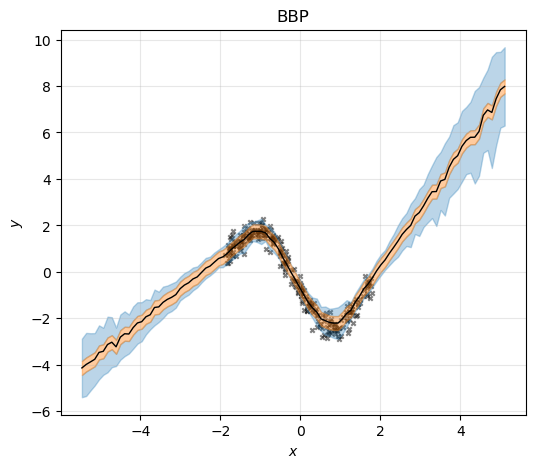

In [86]:
x_mean, x_std = Dropout.x_means.cpu().numpy(), Dropout.x_stds.cpu().numpy()
y_mean, y_std = Dropout.y_mean.cpu().numpy(), Dropout.y_std.cpu().numpy()

out = Dropout.prediction(x_domain, train=False)
out = torch.stack(out).cpu().detach().numpy()
out = out*y_std + y_mean

means = out.mean(axis = 0)

# aleatoric = 1/np.sqrt(BBB.model.log_noise.cpu().exp().detach().item())
aleatoric = 1/np.sqrt(model_params['noise_prec'])*y_std
epistemic = out.var(axis = 0)**0.5

fig = plot_curve(x_train, y_train, x_domain.view(-1).cpu().numpy()*x_std + x_mean,  means, aleatoric, epistemic)

## Variational Adam (Vadam)

In [13]:
model_params={'hidden_sizes': [100],
              'act_func': 'relu' ,
              'dropout': 0.05 ,
              'prior_prec': lengthscale, # lengthscale = 1
              'noise_prec': 1/sig_noise**2 * y_train.var()}

train_params={'batch_size': len(x_train),
              'num_epochs': 10000, # 20000
              'seed': 2,
              'train_mc_samples': 1,
              'eval_mc_samples': 100}

optim_params={'optim': 'adam',
              'learning_rate': 0.1,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

dataset = 'toydata1d'
data_params={'x_points': (x_train, x_test),
             'y_points': (y_train, y_test)}

Vadam = ExperimentVadamMLPReg(dataset,
                        model_params,
                        train_params,
                        optim_params,
                        data_params=data_params,
                        evals_per_epoch=1,
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=199
    )
Vadam.run(log_metric_history=False)

Dataset: toydata1d   , Epoch [ 1/2000], Loss: 76.8525 Batch time: 0.012 (0.012) Data time: 0.002 (0.002) 
Dataset: toydata1d   , Epoch [200/2000], Loss: -0.1732 Batch time: 0.018 (0.018) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [399/2000], Loss: 0.0777 Batch time: 0.038 (0.038) Data time: 0.004 (0.004) 
Dataset: toydata1d   , Epoch [598/2000], Loss: 0.0377 Batch time: 0.011 (0.011) Data time: 0.002 (0.002) 
Dataset: toydata1d   , Epoch [797/2000], Loss: 0.4841 Batch time: 0.012 (0.012) Data time: 0.002 (0.002) 
Dataset: toydata1d   , Epoch [996/2000], Loss: 0.2141 Batch time: 0.019 (0.019) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [1195/2000], Loss: -0.0100 Batch time: 0.020 (0.020) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [1394/2000], Loss: -0.2217 Batch time: 0.020 (0.020) Data time: 0.004 (0.004) 
Dataset: toydata1d   , Epoch [1593/2000], Loss: -0.1195 Batch time: 0.021 (0.021) Data time: 0.003 (0.003) 
Dataset: toydata1d   , Epoch [1792/2000

-0.2305726557970047

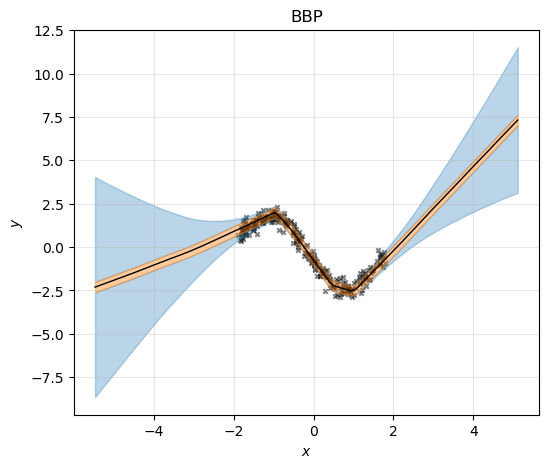

In [14]:
x_mean, x_std = Vadam.x_means.cpu().numpy(), Vadam.x_stds.cpu().numpy()
y_mean, y_std = Vadam.y_mean.cpu().numpy(), Vadam.y_std.cpu().numpy()

out = Vadam.prediction(x_domain, train=False)
out = torch.stack(out).cpu().detach().numpy()
out = out*y_std + y_mean

means = out.mean(axis = 0)

# aleatoric = 1/np.sqrt(BBB.model.log_noise.cpu().exp().detach().item())
aleatoric = 1/np.sqrt(model_params['noise_prec'])*y_std
epistemic = out.var(axis = 0)**0.5

fig = plot_curve(x_train, y_train, x_domain.view(-1).cpu().numpy()*x_std + x_mean, means, aleatoric, epistemic)

In [ ]:
out = Vadam.prediction((x_domain - x_mean)/x_std, train=False)
out = torch.stack(out).cpu().detach.numpy()
out = out*y_std.numpy() + y_mean.numpy()

plot_1d_results((data_1.train_set.train_data.numpy(), data_1.train_set.train_labels.numpy()),
                 {'mean':base_model, 'std':noise_model}, (x_domain.numpy(), out, 1/model_params['noise_prec']),
                 method = 'vadam')

# filename = 'ex1_vadam.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

## Probabilistic Backpropagation (PBP)

In [118]:
model_params={'hidden_sizes': [100]}

train_params={'num_epochs': 40,
              'seed': 2}

dataset = 'toydata1d'
data_params={'x_points': (x_train, x_test),
             'y_points': (y_train, y_test)}

PBP = ExperimentPBPReg(dataset,
                        model_params,
                        train_params,
                        data_params,
                        experiment_prefix='toydata',
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=9
    )
PBP.run()

Epoch [1/40], Train RMSE: 0.8432, Test RMSE: 3.4309, Logloss: -1.3110, Test Logloss: -2.7421 Eval time: 0.039Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
Epoch [10/40], Train RMSE: 0.3057, Test RMSE: 3.3225, Logloss: -0.3155, Test Logloss: -10.1839 Eval time: 0.042Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
Epoch [19/40], Train RMSE: 0.2969, Test RMSE: 3.5464, Logloss: -0.2331, Test Logloss: -19.3114 Eval time: 0.036Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
Epoch [28/40], Train RMSE: 0.2961, Test RMSE: 3.6253, Logloss: -0.2152, Test Logloss: -25.1437 Eval time: 0.032Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
Epoch [37/40], Train RMSE: 0.2957, Test RMSE: 3.6715, Logloss: -0.2079, Test Logloss: -29.0424 Eval time: 0.031Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
toydata1d train time 6.468 (6.468)	


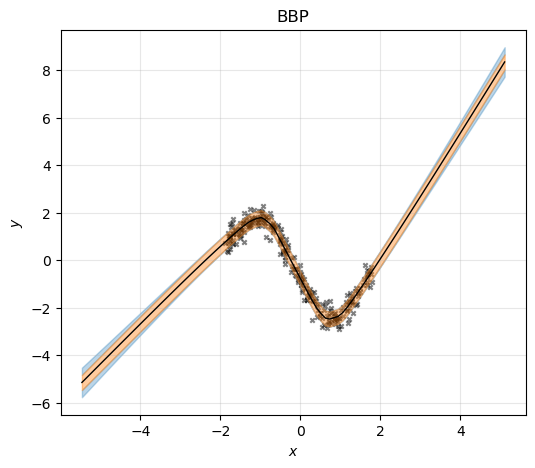

In [119]:
x_mean, x_std = PBP.x_means.cpu().numpy(), PBP.x_stds.cpu().numpy()
y_mean, y_std = PBP.y_mean.cpu().numpy(), PBP.y_std.cpu().numpy()

# Model outpus are already *unnormalized*
m, v, v_noise = PBP.model.predict(x_domain.numpy())

means = out.mean(axis = 0)

# aleatoric = 1/np.sqrt(BBB.model.log_noise.cpu().exp().detach().item())
aleatoric = v_noise**0.5
epistemic = v**0.5

fig = plot_curve(x_train, y_train, x_domain.view(-1).cpu().numpy()*x_std + x_mean, m, aleatoric, epistemic)

# filename = 'ex1_pbp.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

# Toy set #2

https://github.com/ThirstyScholar/bayes-by-backprop/blob/master/BBB/bnn_regression.py  
https://arxiv.org/pdf/1502.05336.pdf

In [121]:
def base_model(x):
    return x**3

def noise_model(x):
    return 3*np.ones_like(x)

def sample_data(x):
    return base_model(x) + np.random.normal(0, noise_model(x))

In [122]:
train_size, test_size = 20, 100

# X values: U[-4, 4]
train_data_2 = np.random.uniform(-4, 4, size=train_size).reshape((-1, 1))
test_data_2 = np.random.uniform(-4, 4, size=test_size).reshape((-1, 1))

train_labels_2 = sample_data(train_data_2)
test_labels_2 = sample_data(test_data_2)

# # X domain for visualizing learned model
x_domain = torch.linspace(-6,6,100)[..., None]


## BBB

In [211]:
model_params={'hidden_sizes': [100],
              'act_func': 'relu' ,
              'prior_prec': 1.0,
              'noise_prec': 1/9 * train_labels_2.var()}

train_params={'batch_size': len(train_data_2),
              'num_epochs': 2000, # 20000
              'seed': 2,
              'train_mc_samples': 10,
              'eval_mc_samples': 100}

optim_params={'optim': 'adam',
              'learning_rate': 0.1,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

dataset = 'toydata1d'
data_params={'x_points': (train_data_2, test_data_2),
             'y_points': (train_labels_2, test_labels_2)}

BBB = ExperimentBBBMLPReg(dataset,
                            model_params,
                            train_params,
                            optim_params,
                            data_params=data_params,
                            evals_per_epoch=1,
                            normalize_x=True,
                            normalize_y=True,
                            use_cuda=torch.cuda.is_available(),
                            print_freq=199
    )
BBB.run(log_metric_history=False)

Dataset: toydata1d   , Epoch [ 1/2000], Loss: 29.7651 Batch time: 0.009 (0.009) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [200/2000], Loss: 13.8462 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [399/2000], Loss: 13.1458 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [598/2000], Loss: 13.4780 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [797/2000], Loss: 15.9956 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [996/2000], Loss: 14.0080 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [1195/2000], Loss: 14.3916 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [1394/2000], Loss: 13.2985 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [1593/2000], Loss: 13.1313 Batch time: 0.008 (0.008) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [1792/

12.21296501159668

(-100, 100)

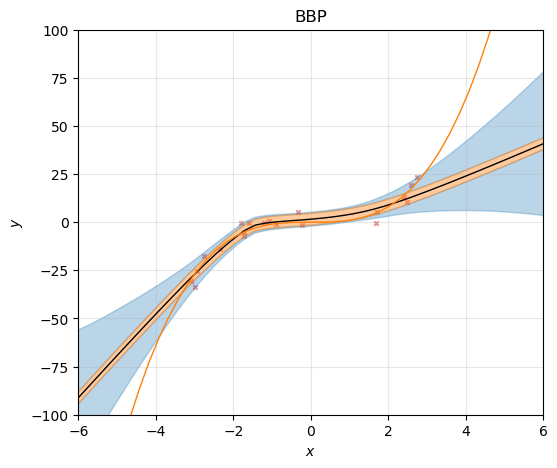

In [216]:
x_mean, x_std = BBB.x_means.cpu().numpy(), BBB.x_stds.cpu().numpy()
y_mean, y_std = BBB.y_mean.cpu().numpy(), BBB.y_std.cpu().numpy()

out = BBB.prediction(x_domain, train=False)
out = torch.stack(out).cpu().detach().numpy()
out = out*y_std.numpy() + y_mean.numpy()

aleatoric = 1/np.sqrt(model_params['noise_prec'])*y_std.numpy()
epistemic = out.var(axis = 0)**0.5

fig = plot_curve(train_data_2, train_labels_2,
                 x_domain.view(-1)*x_std + x_mean, m,
                 aleatoric, epistemic,
                 ideal_output=base_model(x_domain.view(-1).cpu()*x_std+x_mean))

plt.xlim([-6, 6])
plt.ylim([-100, 100])

# filename = 'ex2_bbb.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

## MC Dropout

In [241]:
model_params={'hidden_sizes': [100],
              'act_func': 'relu' ,
              'dropout': 0.2,
              'prior_prec': 1.0,
              'noise_prec': 1/9 * train_labels_2.var()}

train_params={'batch_size': len(train_data_2),
              'num_epochs': 10000, # 20000
              'seed': 2,
              'train_mc_samples': 1,
              'eval_mc_samples': 100}

optim_params={'optim': 'adam',
              'learning_rate': 0.1,
              'betas': (0.9,0.99),
              'prec_init': 10.0}

dataset = 'toydata1d'
data_params={'x_points': (train_data_2, test_data_2),
             'y_points': (train_labels_2, test_labels_2)}

In [242]:
Dropout = ExperimentDropoutMLPReg(dataset,
                                    model_params,
                                    train_params,
                                    optim_params,
                                    data_params=data_params,
                                    evals_per_epoch=1,
                                    normalize_x=True,
                                    normalize_y=True,
                                    use_cuda=torch.cuda.is_available(),
                                    print_freq=2000)

Dropout.run(log_metric_history=False)

Dataset: toydata1d   , Epoch [ 1/10000], Loss: 0.5088 Batch time: 0.002 (0.002) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [2001/10000], Loss: 0.0492 Batch time: 0.001 (0.001) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [4001/10000], Loss: 0.1217 Batch time: 0.001 (0.001) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [6001/10000], Loss: 0.1761 Batch time: 0.001 (0.001) Data time: 0.000 (0.000) 
Dataset: toydata1d   , Epoch [8001/10000], Loss: 0.0687 Batch time: 0.001 (0.001) Data time: 0.000 (0.000) 
toydata1d train time 14.778 (14.778)	


0.015158336609601974

<IPython.core.display.Javascript object>


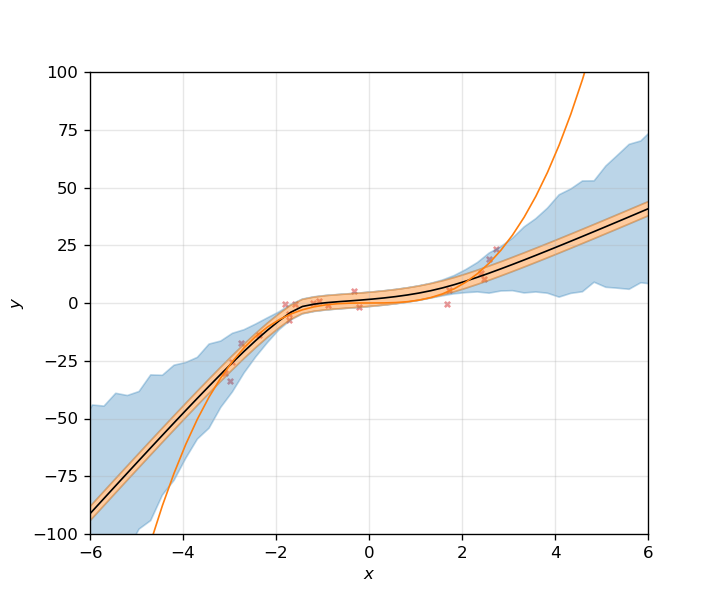

(-100, 100)

In [247]:
x_mean, x_std = Dropout.x_means.cpu().numpy(), Dropout.x_stds.cpu().numpy()
y_mean, y_std = Dropout.y_mean.cpu().numpy(), Dropout.y_std.cpu().numpy()

out = Dropout.prediction(x_domain, train=False)
out = torch.stack(out).cpu().detach().numpy()
out = out*y_std + y_mean

means = out.mean(axis = 0)

aleatoric = 1/np.sqrt(model_params['noise_prec'])*y_std
epistemic = out.var(axis = 0)**0.5


fig = plot_curve(train_data_2, train_labels_2,
                 x_domain.view(-1).numpy()*x_std + x_mean, m,
                 aleatoric, epistemic,
                 ideal_output=base_model(x_domain.view(-1).cpu().numpy()*x_std+x_mean))

plt.xlim([-6, 6])
plt.ylim([-100, 100])

# filename = 'ex2_mcdropout.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

## Vadam

In [223]:
Vadam = ExperimentVadamMLPReg(dataset,
                        model_params,
                        train_params,
                        optim_params,
                        data_params=data_params,
                        evals_per_epoch=1,
                        normalize_x=False,
                        normalize_y=False,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=1000
    )
Vadam.run()

Epoch [1/10000], Neg. Ave. ELBO: 1546.0652, Logloss: 1306.8496, Test Logloss: 4393.9541 Eval time: 0.000Batch time: 0.005 (0.005) Data time: 0.000 (0.000) 
Epoch [1001/10000], Neg. Ave. ELBO: 123.0625, Logloss: 72.5769, Test Logloss: 249.3129 Eval time: 0.000Batch time: 0.002 (0.002) Data time: 0.000 (0.000) 
Epoch [2001/10000], Neg. Ave. ELBO: 116.7937, Logloss: 72.6997, Test Logloss: 297.5329 Eval time: 0.000Batch time: 0.002 (0.002) Data time: 0.000 (0.000) 
Epoch [3001/10000], Neg. Ave. ELBO: 115.4572, Logloss: 71.7994, Test Logloss: 328.2751 Eval time: 0.000Batch time: 0.002 (0.002) Data time: 0.000 (0.000) 
Epoch [4001/10000], Neg. Ave. ELBO: 121.3128, Logloss: 73.3708, Test Logloss: 329.3019 Eval time: 0.000Batch time: 0.002 (0.002) Data time: 0.000 (0.000) 
Epoch [5001/10000], Neg. Ave. ELBO: 115.4051, Logloss: 71.2431, Test Logloss: 304.9088 Eval time: 0.000Batch time: 0.002 (0.002) Data time: 0.000 (0.000) 
Epoch [6001/10000], Neg. Ave. ELBO: 115.0210, Logloss: 70.4601, Test 

69.3497543334961

(-100, 100)

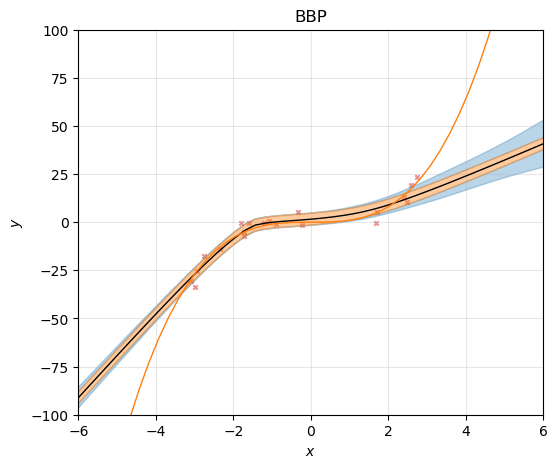

In [224]:
x_mean, x_std = Vadam.x_means.cpu().numpy(), Vadam.x_stds.cpu().numpy()
y_mean, y_std = Vadam.y_mean.cpu().numpy(), Vadam.y_std.cpu().numpy()

out = Vadam.prediction(x_domain, train=False)
out = torch.stack(out).cpu().detach().numpy()
out = out*y_std.numpy() + y_mean.numpy()

means = out.mean(axis = 0)

aleatoric = 1/np.sqrt(model_params['noise_prec'])*y_std.numpy()
epistemic = out.var(axis = 0)**0.5


fig = plot_curve(train_data_2, train_labels_2,
                 x_domain.view(-1)*x_std + x_mean, m,
                 aleatoric, epistemic,
                 ideal_output=base_model(x_domain.view(-1).cpu()*x_std+x_mean))

plt.xlim([-6, 6])
plt.ylim([-100, 100])

# filename = 'ex2_vadam.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

## PBP

In [129]:
model_params={'hidden_sizes': [100]}

train_params={'batch_size': len(train_data_2),
              'num_epochs': 40,
              'seed': 2}

dataset = 'toydata1d'
data_params={'x_points': (train_data_2, test_data_2),
             'y_points': (train_labels_2, test_labels_2)}

PBP = ExperimentPBPReg(dataset,
                        model_params,
                        train_params,
                        data_params,
                        experiment_prefix='toydata',
                        normalize_x=True,
                        normalize_y=True,
                        use_cuda=torch.cuda.is_available(),
                        print_freq=39
    )
PBP.run()

Epoch [1/40], Train RMSE: 9.0291, Test RMSE: 16.9417, Logloss: -4.0992, Test Logloss: -4.3303 Eval time: 0.011Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
Epoch [40/40], Train RMSE: 4.0464, Test RMSE: 9.5953, Logloss: -2.8898, Test Logloss: -3.5229 Eval time: 0.015Batch time: 0.000 (0.000) Data time: 0.000 (0.000) 
toydata1d train time 1.209 (1.209)	


(-100, 100)

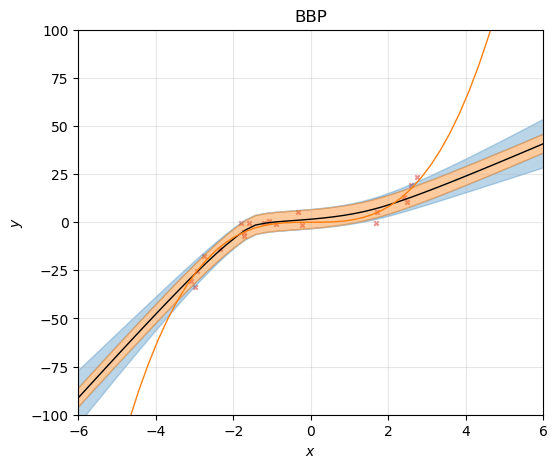

In [187]:
x_mean, x_std = PBP.x_means.cpu().numpy(), PBP.x_stds.cpu().numpy()
y_mean, y_std = PBP.y_mean.cpu().numpy(), PBP.y_std.cpu().numpy()

# Model outpus are already *unnormalized*
m, v, v_noise = PBP.model.predict(x_domain.numpy())

means = out.mean(axis = 0)

aleatoric = v_noise**0.5
epistemic = v**0.5

fig = plot_curve(train_data_2, train_labels_2,
                 x_domain.view(-1).cpu().numpy()*x_std + x_mean, m,
                 aleatoric, epistemic,
                 ideal_output=base_model(x_domain.view(-1).cpu().numpy()*x_std+x_mean))

plt.xlim([-6, 6])
plt.ylim([-100, 100])

# filename = 'ex2_pbp.pdf'
# fig.savefig( 'images/toy-example'+ filename, bbox_inches='tight', dpi=200)

# Toy set #3

https://arxiv.org/pdf/1505.05424.pdf

 $$y=x+ 0.3 sin(2π(x+\epsilon)) + 0.3 sin(4π(x+\epsilon)) + \epsilon,  where \epsilon ∼ N(0,0.02) $$